# Cybersecurity Intrusion Detection

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score,accuracy_score
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('cybersecurity_intrusion_data.csv')

# Cybersecurity Intrusion Detection

## 1. Descriptive Analysis

In [3]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (9537, 11)


The dataset contains 9537 rows and 11 features.

The dataset includes network and user behavior features used to detect potential cybersecurity intrusions. Each row represents a signle network session, and the target variable indicates whether the session was normal or an attack.

The variables of the dataset are :
- session_id : unique identifier for each network session
- network_packet_size : size of network packets in bytes
- protocol_type : communication protocol used (TCP, UDP, ICMP)
- login_attemps : number of login attemps in a session
- session_duration : duration of the session in seconds
- encryption_used : encryption protocol used (AES, DES)
- ip_reputation_score : trust score of the IP address (between 0 and 1) --> the closer this score is to 1, the more suspicious it is
- failed_logins : number of failed login attemps
- browser_type : type of browser used (Chrome, Firefox, Edge, Safari)
- unusual_time_access : binary indicator (0 or 1) showing if the access occured at an unusual time
- attack_detected (target variable) : 1 means attack detected and 0 means normal activity

**Overview of the dataset :**

In [4]:
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [5]:
df.dtypes

session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object

In [6]:
df.describe()

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,500.430639,4.032086,792.745312,0.331338,1.517773,0.149942,0.447101
std,198.379364,1.963012,786.560144,0.177175,1.033988,0.357034,0.497220
min,64.000000,1.000000,0.500000,0.002497,0.000000,0.000000,0.000000
25%,365.000000,3.000000,231.953006,0.191946,1.000000,0.000000,0.000000
50%,499.000000,4.000000,556.277457,0.314778,1.000000,0.000000,0.000000
75%,635.000000,5.000000,1105.380602,0.453388,2.000000,0.000000,1.000000
max,1285.000000,13.000000,7190.392213,0.924299,5.000000,1.000000,1.000000


The summary statistics provide an overview of the numerical features in the dataset :
- On average, users make around 4 login attemps, which suggests normal authentification behavior, though some reach up to 13 attempts (possible brute-force indicators)
- The session duration varies greatly (from less than 1 second to over 7000 seconds) : long sessions may suggest persistent access or suspicious activity
- The IP reputation score ranges from 0 to 0.92, with an average around 0.33 showing that most IPs are relatively trustworthy but a few are risky.
- The average number of failed login attemps is 1.5 with a maximum of 5 : the highest values could be linked to cyberattacks

**Check for missing values :**

In [7]:
print(df.isnull().sum())

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


We can see that there are 1,966 missing values in the dataset.

**Check class imbalance :**

Class distribution:
 attack_detected
0    5273
1    4264
Name: count, dtype: int64
Imbalance ratio ≈ 1:1.24


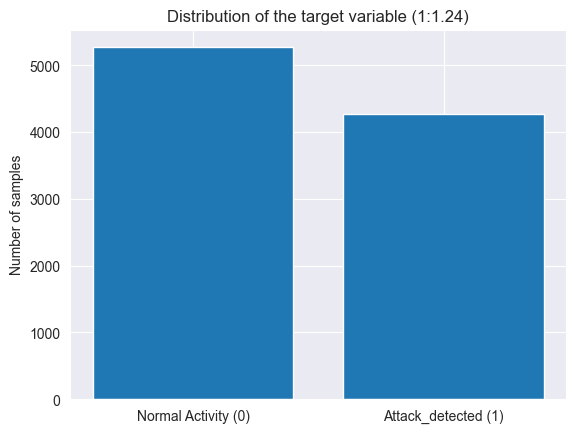

In [8]:
class_counts = df['attack_detected'].value_counts()
print("Class distribution:\n", class_counts)

minority = class_counts.min()
majority = class_counts.max()
ratio = majority / minority
print(f"Imbalance ratio ≈ 1:{ratio:.2f}")

plt.bar(['Normal Activity (0)', 'Attack_detected (1)'], class_counts)
plt.title(f"Distribution of the target variable (1:{ratio:.2f})")
plt.ylabel("Number of samples")
plt.show()

### Numerical features

**Correlation matrix**

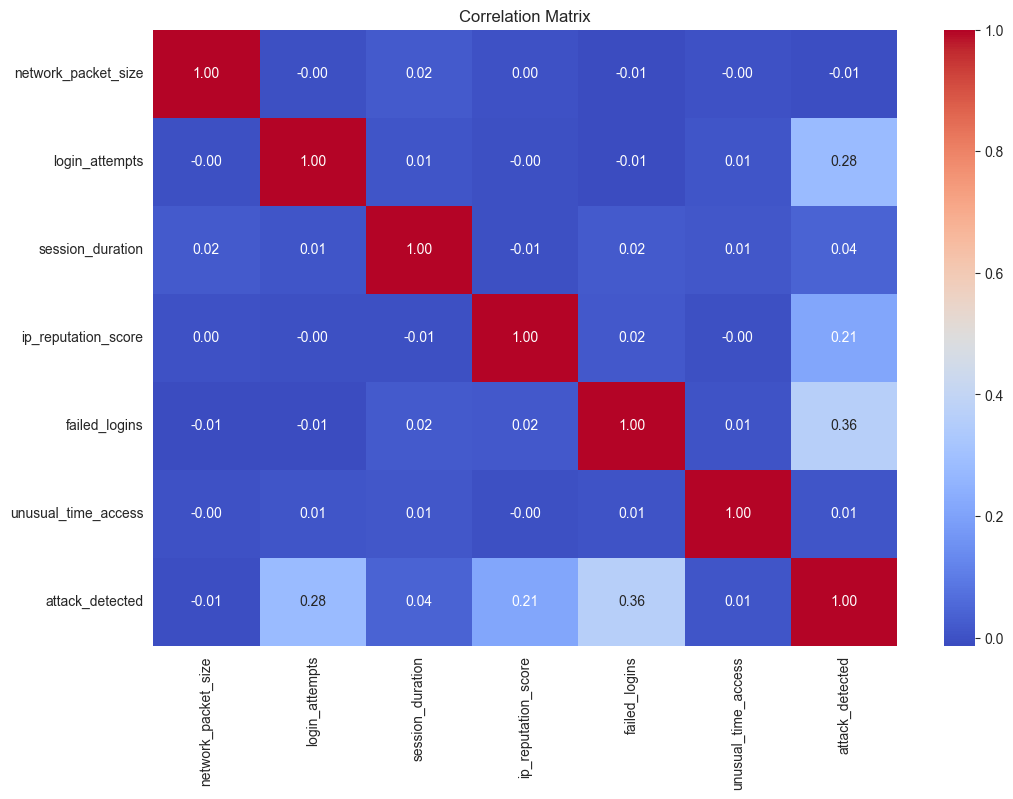

In [9]:
# Sélection des colonnes numériques
numeric_cols = df.select_dtypes(include=np.number)

# Matrice de corrélation
plt.figure(figsize=(12,8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The correlation matrix highlights that the variables failed_logins (0.36), login_attempts (0.28) and ip_reputation_score (0.21) are those with the strongest links to the target variable attack_detected. This suggests that a significant number of failed logins or login attempts increases the probability of an attack being detected. Inversely, variables such as network_packet_size, session_duration, and unusual_time_access show correlations close to zero, indicating no significant linear relationship with attack detection.

In this analysis, we tested several resampling techniques. However, the data is nearly balanced (imbalance ratio = 1:1.24), and resampling did not improve model performance. Therefore, we decided not to apply resampling in the upcoming models.

**Correlation matrix of the numerical features and the target**

attack_detected        1.000000
failed_logins          0.363726
login_attempts         0.277320
ip_reputation_score    0.211540
session_duration       0.041602
unusual_time_access    0.008652
network_packet_size   -0.006798
Name: attack_detected, dtype: float64


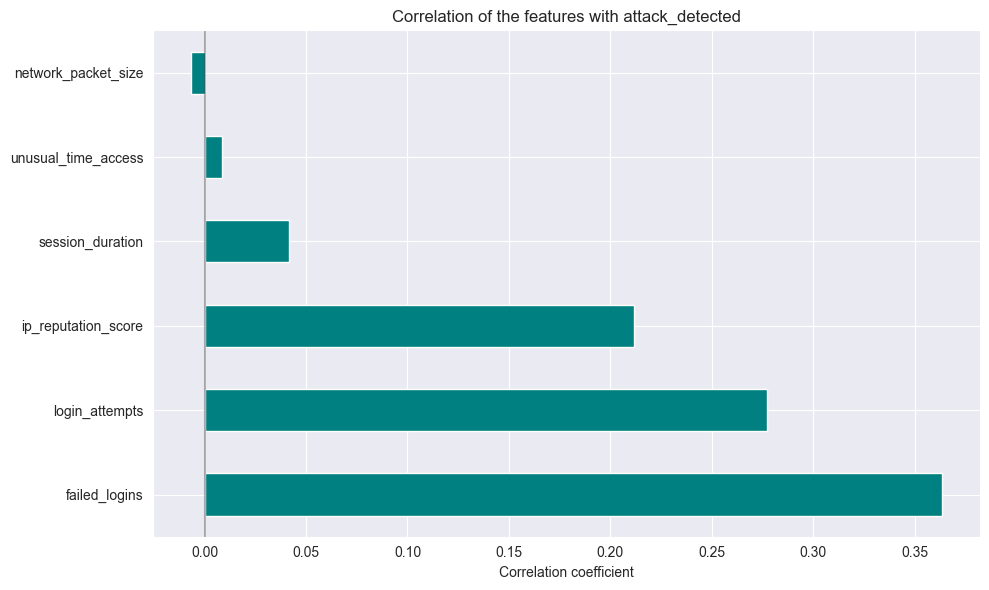

In [10]:
# Correlation with the target
numerical_features = [col for col in numeric_cols if col != 'attack_detected']
correlation_matrix = df[numerical_features + ['attack_detected']].corr()
target_correlation = correlation_matrix['attack_detected'].sort_values(ascending=False)
print(target_correlation)

# Visualization of the correlation with the target
plt.figure(figsize=(10, 6))
target_correlation.drop('attack_detected').plot(kind='barh', color='teal')
plt.title('Correlation of the features with attack_detected')
plt.xlabel('Correlation coefficient')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

**Box plots of the numerical features**

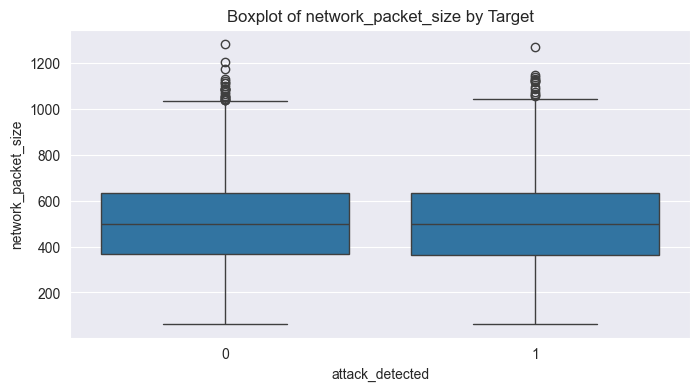

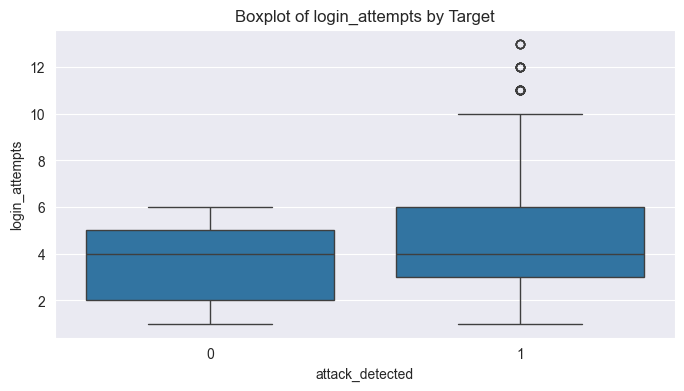

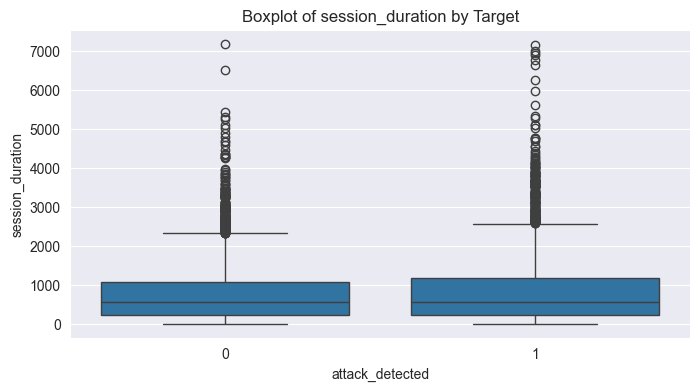

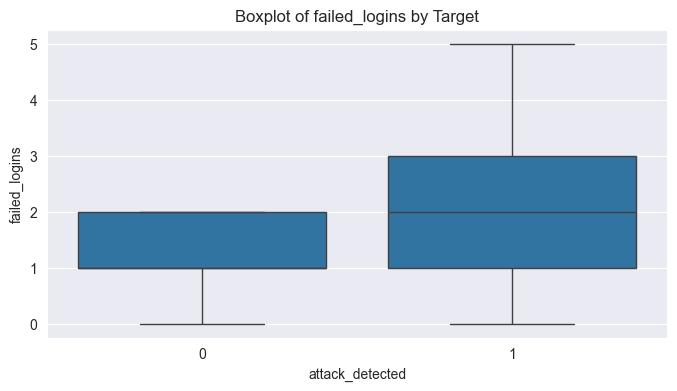

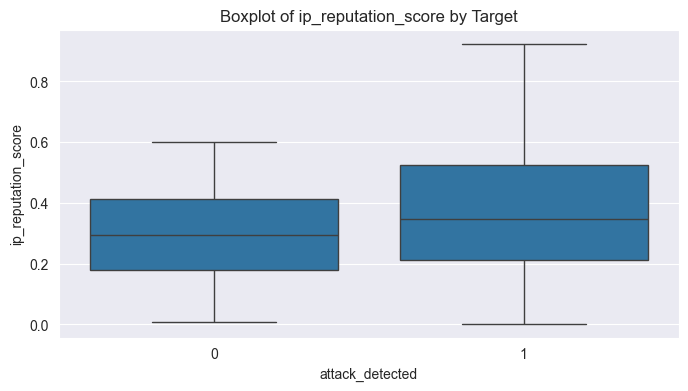

In [11]:
numerical_features = ['network_packet_size', 'login_attempts', 'session_duration', 'failed_logins', 'ip_reputation_score']

for feature in numerical_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='attack_detected', y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Target')
    plt.show()

## Object features

**Protocol type**

Protocol type distribution
protocol_type
TCP     6624
UDP     2406
ICMP     507
Name: count, dtype: int64


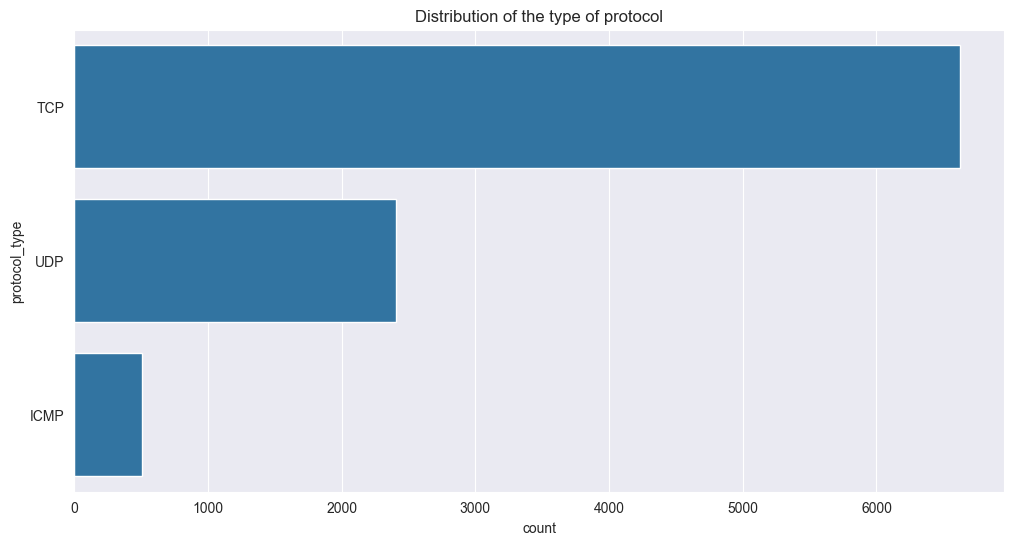

Text(0.5, 1.0, 'Protocol type pie chart')

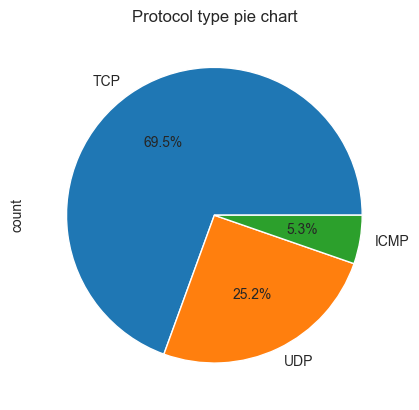

In [12]:
print("Protocol type distribution")
print(df['protocol_type'].value_counts(normalize=False))

plt.figure(figsize=(12,6))
sns.countplot(y='protocol_type', data=df, order=df['protocol_type'].value_counts().index)
plt.title('Distribution of the type of protocol')
plt.show()

df['protocol_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Protocol type pie chart')

**Encryption used**

Encryption used distribution
encryption_used
AES    4706
DES    2865
Name: count, dtype: int64


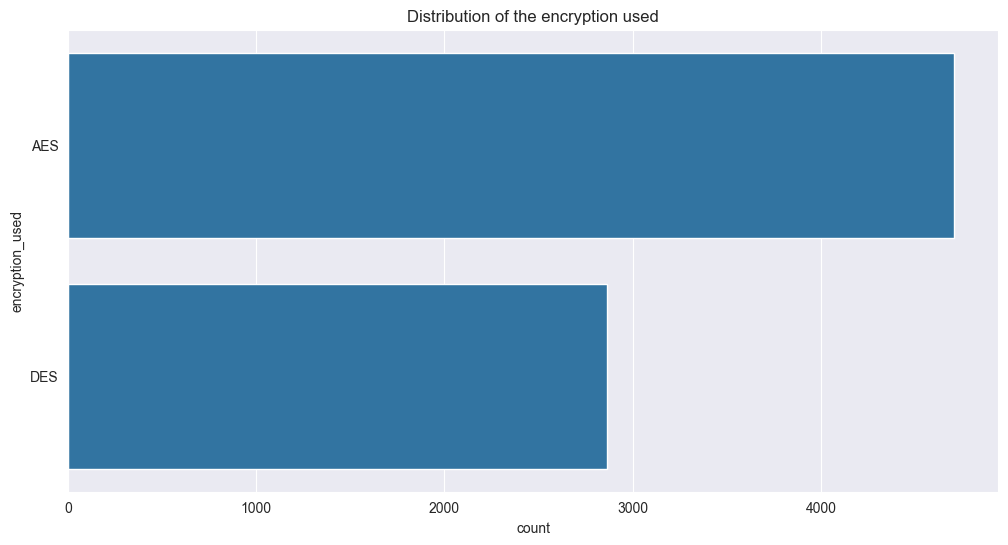

Text(0.5, 1.0, 'Encryption used pie chart')

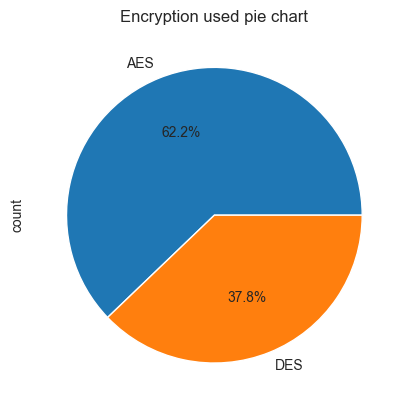

In [13]:
print("Encryption used distribution")
print(df['encryption_used'].value_counts(normalize=False))

plt.figure(figsize=(12,6))
sns.countplot(y='encryption_used', data=df, order=df['encryption_used'].value_counts().index)
plt.title('Distribution of the encryption used')
plt.show()

df['encryption_used'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Encryption used pie chart')

**Browser type**

Browser type distribution
browser_type
Chrome     5137
Firefox    1944
Edge       1469
Unknown     502
Safari      485
Name: count, dtype: int64


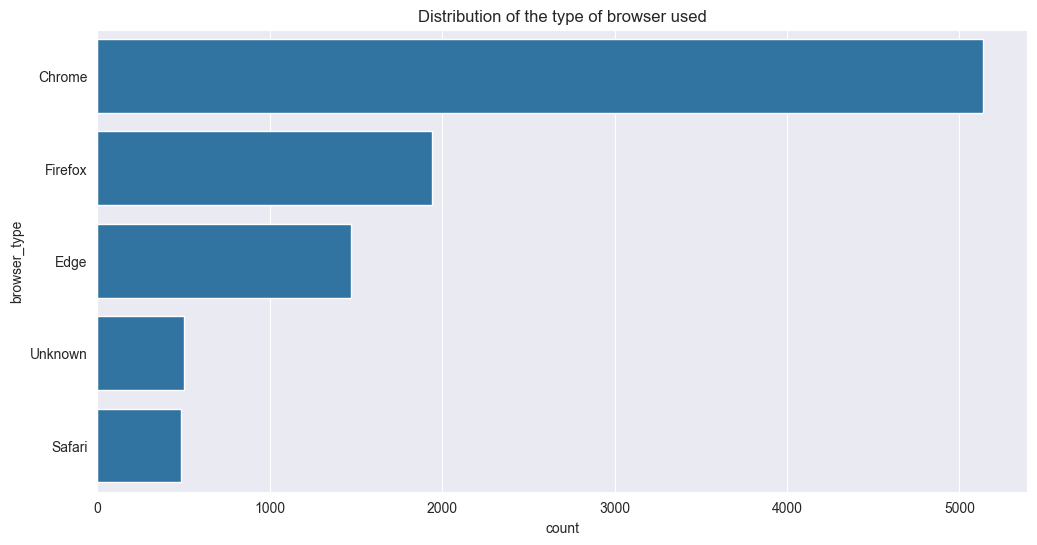

Text(0.5, 1.0, 'Browser type pie chart')

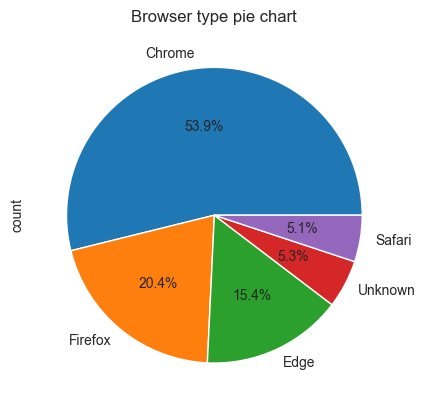

In [14]:
print("Browser type distribution")
print(df['browser_type'].value_counts(normalize=False))

plt.figure(figsize=(12,6))
sns.countplot(y='browser_type', data=df, order=df['browser_type'].value_counts().index)
plt.title('Distribution of the type of browser used')
plt.show()

df['browser_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Browser type pie chart')

**Cross analysis with attack_detected**

In [15]:
# Protocol_type vs Attack
protocol_attack = pd.crosstab(df['protocol_type'], df['attack_detected'], normalize='index') * 100
print("Protocol_type vs Attack (%):")
print(protocol_attack.round(2))

# Encryption_used vs Attack
encryption_attack = pd.crosstab(df['encryption_used'], df['attack_detected'], normalize='index') * 100
print("\nEncryption_used vs Attack (%):")
print(encryption_attack.round(2))

# Browser_type vs Attack
browser_attack = pd.crosstab(df['browser_type'], df['attack_detected'], normalize='index') * 100
print("\nBrowser_type vs Attack (%):")
print(browser_attack.round(2))

Protocol_type vs Attack (%):
attack_detected      0      1
protocol_type                
ICMP             58.78  41.22
TCP              55.27  44.73
UDP              54.61  45.39

Encryption_used vs Attack (%):
attack_detected      0      1
encryption_used              
AES              56.33  43.67
DES              54.66  45.34

Browser_type vs Attack (%):
attack_detected      0      1
browser_type                 
Chrome           57.13  42.87
Edge             56.23  43.77
Firefox          56.33  43.67
Safari           58.14  41.86
Unknown          26.89  73.11


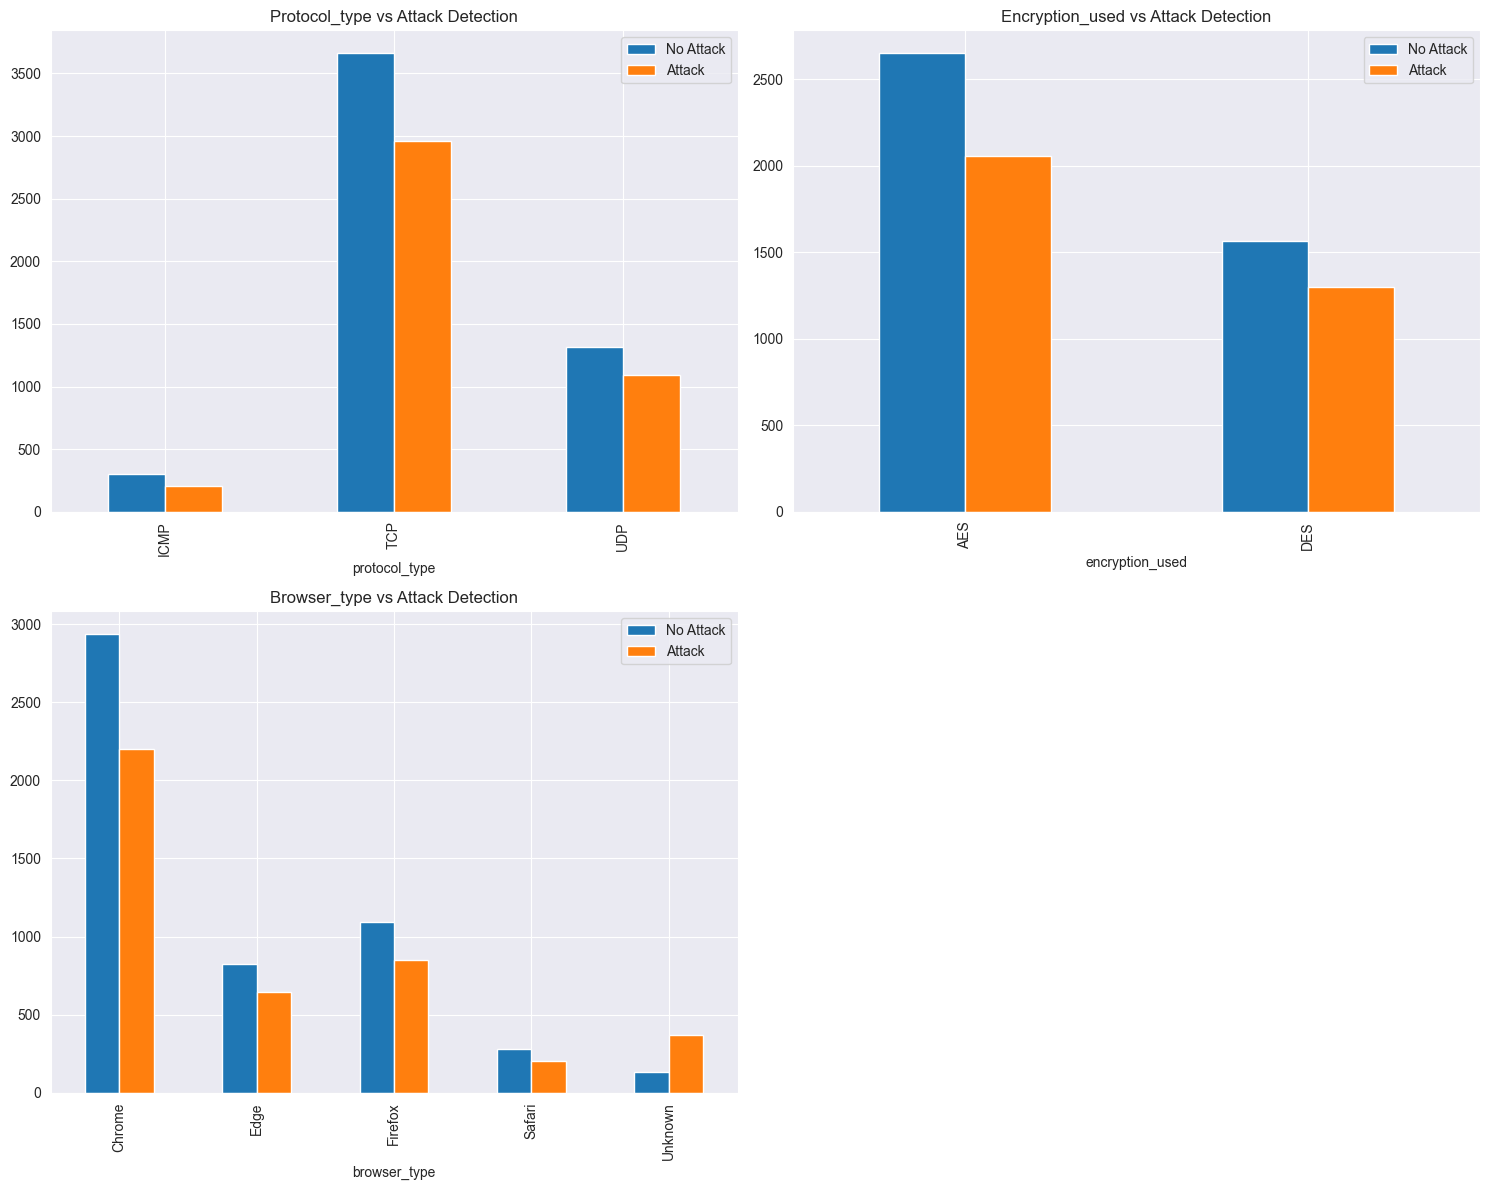

In [16]:
# Visualization of the cross-analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Protocol_type
pd.crosstab(df['protocol_type'], df['attack_detected']).plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Protocol_type vs Attack Detection')
axes[0,0].legend(['No Attack', 'Attack'])

# Encryption_used
pd.crosstab(df['encryption_used'], df['attack_detected']).plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Encryption_used vs Attack Detection')
axes[0,1].legend(['No Attack', 'Attack'])

# Browser_type
pd.crosstab(df['browser_type'], df['attack_detected']).plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Browser_type vs Attack Detection')
axes[1,0].legend(['No Attack', 'Attack'])

# Attack rate by category
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

### Pre-processing

**Handling missing values**

In [17]:
df['encryption_used'].fillna('Unknown', inplace=True)

C:\Users\itoda\AppData\Local\Temp\ipykernel_16536\651670891.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['encryption_used'].fillna('Unknown', inplace=True)


**Encode categorial features**

In [18]:
categorical_features = ['protocol_type', 'encryption_used', 'browser_type']

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

**Train/test split**

In [19]:
from sklearn.model_selection import train_test_split

X = df.drop(['attack_detected', 'session_id'], axis=1)

y = df['attack_detected']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (7629, 14), Test size: (1908, 14)


**Resampling analysis**

In [20]:
samplers = {
    "No Rebalancing": None,
    "Random OverSampling": RandomOverSampler(random_state=42),
    "Random UnderSampling": RandomUnderSampler(random_state=42)
}

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
conf_matrices = {}

for name, sampler in samplers.items():
    print(f"\n=== {name} ===")

    X_res, y_res = (X_train, y_train)
    if sampler:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    print("Class distribution after sampling:", Counter(y_res))

    model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')

    f1_scores, auc_scores = [], []
    conf_sum = np.zeros((2,2))

    for train_idx, val_idx in cv.split(X_res, y_res):
        X_tr, X_val = X_res.iloc[train_idx], X_res.iloc[val_idx]
        y_tr, y_val = y_res.iloc[train_idx], y_res.iloc[val_idx]


        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:,1]

        f1_scores.append(f1_score(y_val, y_pred))
        auc_scores.append(roc_auc_score(y_val, y_proba))
        conf_sum += confusion_matrix(y_val, y_pred)

    conf_avg = conf_sum / cv.get_n_splits()
    conf_matrices[name] = conf_avg

    results.append({
        'Method': name,
        'F1_mean': np.mean(f1_scores),
        'F1_std': np.std(f1_scores),
        'AUC_mean': np.mean(auc_scores),
        'AUC_std': np.std(auc_scores)
    })



=== No Rebalancing ===
Class distribution after sampling: Counter({0: 4218, 1: 3411})

=== Random OverSampling ===
Class distribution after sampling: Counter({0: 4218, 1: 4218})

=== Random UnderSampling ===
Class distribution after sampling: Counter({0: 3411, 1: 3411})


In [22]:
results_df = pd.DataFrame(results)
print("\n=== Cross-Validation Results ===")
print(results_df.round(3))


=== Cross-Validation Results ===
                 Method  F1_mean  F1_std  AUC_mean  AUC_std
0        No Rebalancing    0.866   0.011     0.887    0.008
1   Random OverSampling    0.865   0.002     0.888    0.003
2  Random UnderSampling    0.866   0.005     0.887    0.005


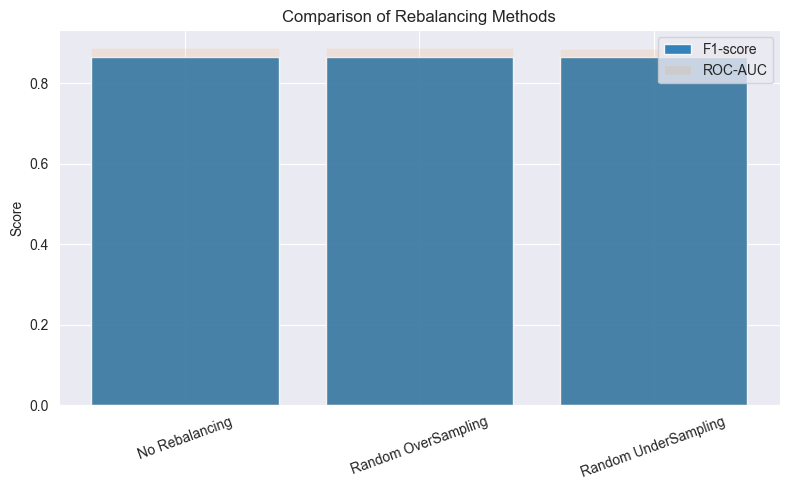

In [23]:
plt.figure(figsize=(8,5))
plt.bar(results_df['Method'], results_df['F1_mean'], alpha=0.9, label='F1-score')
plt.bar(results_df['Method'], results_df['AUC_mean'], alpha=0.1, label='ROC-AUC')
plt.title("Comparison of Rebalancing Methods")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.legend()
plt.tight_layout()
plt.show()

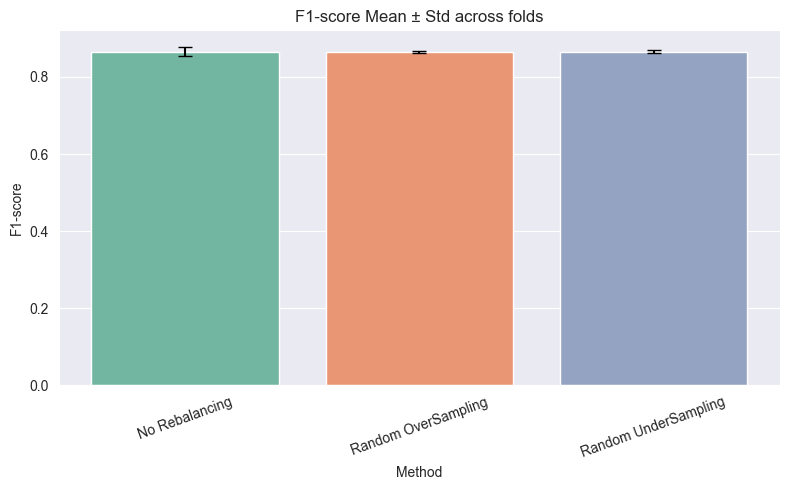

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(x="Method", y="F1_mean", hue="Method", data=results_df, palette="Set2", errorbar=None, legend=False)
plt.errorbar(x=np.arange(len(results_df)), y=results_df["F1_mean"],
             yerr=results_df["F1_std"], fmt='none', ecolor='black', capsize=5)
plt.title("F1-score Mean ± Std across folds")
plt.ylabel("F1-score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In this analysis, we tested several resampling techniques. However, the data is nearly balanced (imbalance ratio = 1:1.24), and resampling did not improve model performance. Therefore, we decided not to apply resampling in the upcoming models.

## 3. Formalization of the problem

The goal of this project is to develop a supervised model capable of detecting cybersecurity intrusion based on network traffic and user behavior

This task is a binary classification problem : the model must predict whether a given network session corresponds to a normal activity (0) or an attack (1).

The input features are : network_packet_size, protocol_type, encryption_used, login_attemps, session_duration, failed_logins, browser_type, unusual_time_access, ip_reputation_score

The output variable is attack_detected which is a binary variable that indicates if the session corresponds to an intrusion (1) or a normal activity (0).

As a baseline model, we will implement a Decision Tree Classifier. We chose this algorithm because it is easy to interpret and quick to train and it can handle both categorical and numerical data.

The baseline model will help us to have a reference performance, which will then enable us to measure the improvements achieved through the application of more advanced models or techniques

# Naive bayes

In [25]:
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)
y_pred_proba = nb_classifier.predict_proba(X_test)[:, 1]  # Probability of class 1

=== Naive Bayes Classifier Results ===

Accuracy: 0.8124
F1-Score: 0.7555
ROC-AUC: 0.8392

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1055
           1       0.91      0.65      0.76       853

    accuracy                           0.81      1908
   macro avg       0.84      0.80      0.80      1908
weighted avg       0.83      0.81      0.81      1908



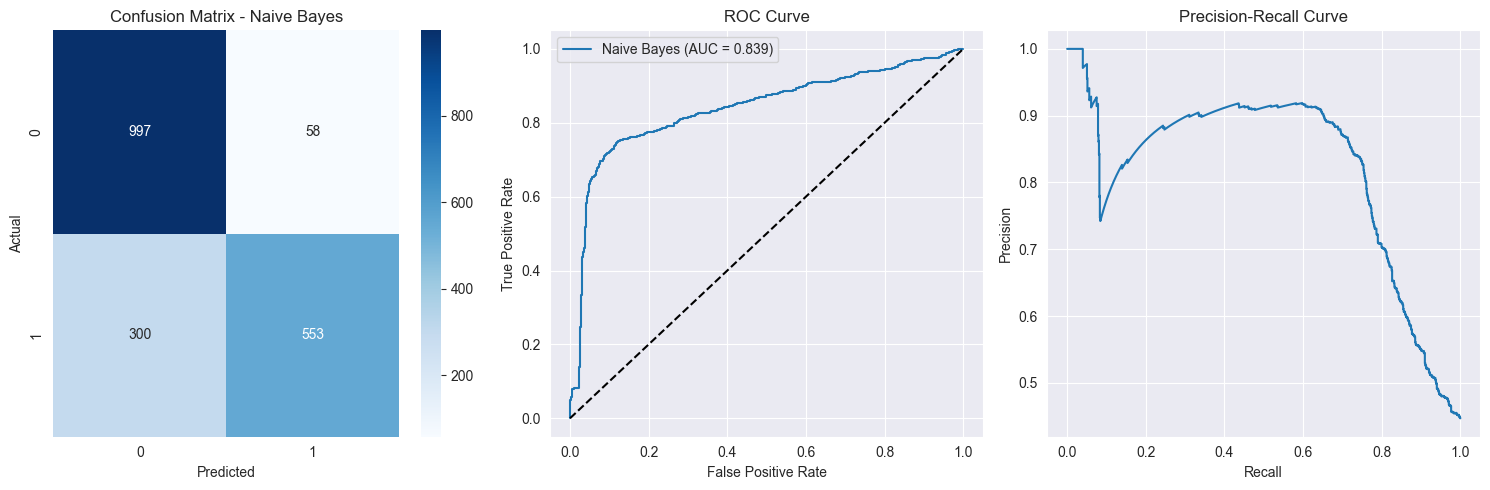

In [26]:
# Evaluate performance
print("=== Naive Bayes Classifier Results ===\n")

# Basic metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {auc_roc:.4f}\n")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

## Neural networks with no categorical variables

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
# Re-copy the dataset just in case
df = pd.read_csv('cybersecurity_intrusion_data.csv')

In [29]:
# Drop categorical columns and identifier
cols_to_drop = ['session_id', 'protocol_type', 'encryption_used', 'browser_type', 'attack_detected']

In [30]:
# Create features and target
X = df.drop(columns=cols_to_drop)
y=df['attack_detected']

In [31]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Building the Neural Network
- Input layer : Matches the number of features we have
- Hidden layers : We use ReLU activation
- Ouput layer : We use Sigmoid activation. It squeezes the output between 0 and 1, effectively giving us the probability of an attack

In [33]:
# 6. Initialize the model
model = Sequential()

# Input Layer + First Hidden Layer
# input_shape should be (number_of_features,)
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))

# Second Hidden Layer
model.add(Dense(32, activation='relu'))

# Dropout Layer (Prevents overfitting by randomly disabling neurons)
model.add(Dropout(0.3))

# Output Layer
# 1 neuron because it's binary classification (0 or 1)
# 'sigmoid' activation forces the output to be between 0 and 1
model.add(Dense(1, activation='sigmoid'))

# 7. Compile the model
model.compile(
    optimizer='adam',                 # Best general-purpose optimizer
    loss='binary_crossentropy',       # Standard loss function for binary classification
    metrics=['accuracy']              # We want to track accuracy
)

model.summary()

C:\Users\itoda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

Traning and evaluation
We use an Early Stopping callback. It stops the training automatically if the validation loss stops improving, which prevents the model frm overfitting

In [34]:
# 8. Define Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,          # Stop if no improvement after 5 epochs
    restore_best_weights=True
)

# 9. Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,           # Maximum epochs
    batch_size=32,       # Updates weights after every 32 rows
    callbacks=[early_stop],
    verbose=1
)

# 10. Evaluate
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# 11. Make Predictions
predictions = (model.predict(X_test_scaled) > 0.5).astype("int32")

Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7356 - loss: 0.5363 - val_accuracy: 0.8019 - val_loss: 0.4632
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8107 - loss: 0.4446 - val_accuracy: 0.8239 - val_loss: 0.4088
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8368 - loss: 0.4016 - val_accuracy: 0.8459 - val_loss: 0.3859
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8503 - loss: 0.3844 - val_accuracy: 0.8532 - val_loss: 0.3711
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8575 - loss: 0.3698 - val_accuracy: 0.8611 - val_loss: 0.3634
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8630 - loss: 0.3612 - val_accuracy: 0.8595 - val_loss: 0.3565
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8622 - loss: 0.3549 - val_accuracy: 0.8611 - val_loss: 0.3521
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8637 - loss: 0.3492 - val_accuracy: 0.

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


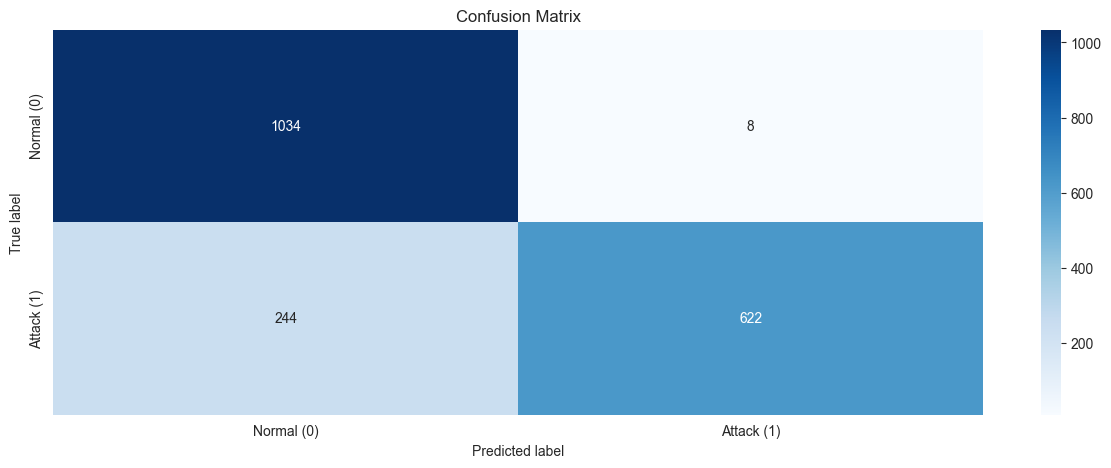


Classification Report:

              precision    recall  f1-score   support

      Normal       0.81      0.99      0.89      1042
      Attack       0.99      0.72      0.83       866

    accuracy                           0.87      1908
   macro avg       0.90      0.86      0.86      1908
weighted avg       0.89      0.87      0.86      1908



In [36]:
# Get the probabilities from the Neural Network
y_pred_proba = model.predict(X_test_scaled)

# Convert Probbilities to classes (0 or 1)
y_pred = (y_pred_proba > 0.5).astype("int32")

# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(15, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Calssification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))
